In [1]:
import os, torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from timm import create_model
from tqdm import tqdm
import numpy as np
import pandas as pd
from PIL import Image

/users/snranepuradewage/.lico_env/jupyter/env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_DIR = "/users/snranepuradewage/roco-dataset-master/data-master"
MODEL_DIR = "/users/snranepuradewage/roco_multimodal/baseline/multitask_experiment/Models_Multitask"
os.makedirs(MODEL_DIR, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

Running on: cuda


In [3]:
concept_train_path = DATA_DIR + "/train_concepts.csv"
caption_train_path = DATA_DIR + "/train_captions.csv"

concept_valid_path = DATA_DIR + "/valid_concepts.csv"
caption_valid_path = DATA_DIR + "/valid_captions.csv"

Created multitask CSVs successfully!


In [ ]:
df_concept_train = pd.read_csv(concept_train_path, sep=",")
df_caption_train = pd.read_csv(caption_train_path, sep=",")

df_concept_valid = pd.read_csv(concept_valid_path, sep=",")
df_caption_valid = pd.read_csv(caption_valid_path, sep=",")

In [ ]:
# Merge on image ID
df_train_merged = pd.merge(df_concept_train, df_caption_train, on="ID")
df_valid_merged = pd.merge(df_concept_valid, df_caption_valid, on="ID")

In [ ]:
df_train_merged.to_csv(DATA_DIR + "/train_multitask.csv", index=False)
df_valid_merged.to_csv(DATA_DIR + "/valid_multitask.csv", index=False)

print("Created multitask CSVs successfully!")

In [4]:
df_train = pd.read_csv(DATA_DIR + "/train_multitask.csv")
df_valid = pd.read_csv(DATA_DIR + "/valid_multitask.csv")

In [5]:
IMG_SIZE = 300
train_transform = transforms.Compose([
    transforms.Resize(int(IMG_SIZE * 1.25)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomCrop((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

In [ ]:
valid_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

In [7]:
from transformers import AutoTokenizer

hf_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

if hf_tokenizer.pad_token is None:
    hf_tokenizer.add_special_tokens({"pad_token": "[PAD]"})

PAD_IDX = hf_tokenizer.pad_token_id
VOCAB_SIZE = hf_tokenizer.vocab_size

print("Tokenizer vocab size:", VOCAB_SIZE, "| PAD_IDX:", PAD_IDX)


Tokenizer vocab size: 30522 | PAD_IDX: 0


In [9]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    imgs, labels, captions = zip(*batch)
    imgs = torch.stack(imgs, 0)
    labels = torch.stack(labels, 0)

    captions = pad_sequence(captions, batch_first=True, padding_value=PAD_IDX)
    return imgs, labels, captions


In [10]:
cuis_list = []
for (i, row) in pd.concat([df_train, df_valid]).iterrows():
    for cui in str(row["CUIs"]).split(";"):
        cui = cui.strip()
        if cui not in cuis_list and cui != "":
            cuis_list.append(cui)

NUM_CONCEPTS = len(cuis_list)
print(f"Total unique CUIs (concepts): {NUM_CONCEPTS}")


Total unique CUIs (concepts): 1947


In [11]:
MAX_LEN = 30

class RocoMTLDataset(Dataset):
    def __init__(self, df, transform=None, tokenizer=None, split="train", max_len=MAX_LEN):
        self.df = df
        self.transform = transform
        self.tokenizer = tokenizer
        self.split = split
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        img_dir = "train" if self.split == "train" else "valid"
        img_path = os.path.join(DATA_DIR, img_dir, row["ID"] + ".jpg")
        
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        # Concept labels encoding
        label_enc = torch.zeros(NUM_CONCEPTS)
        for cui in row["CUIs"].split(";"):
            if cui in cuis_list:
                label_enc[cuis_list.index(cui)] = 1

        text = str(row["Caption"])
        enc = self.tokenizer(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            return_tensors=None
        )
        
        tokens = torch.tensor(enc["input_ids"], dtype=torch.long)

        return img, label_enc, tokens


In [12]:
class MultiTaskModel(nn.Module):
    def __init__(self, num_concepts, vocab_size, embed_dim=512, hidden_dim=512):
        super().__init__()
        
        self.encoder = create_model('efficientnet_b0', pretrained=True, num_classes=0)
        
        # Concept detection head
        self.concept_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(self.encoder.num_features, num_concepts)
        )

        # Caption decoder
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, vocab_size)

    def forward(self, images, captions=None):
        feats = self.encoder.forward_features(images)
        concept_logits = self.concept_head(feats)

        if captions is not None:
            emb = self.embed(captions)
            out, _ = self.lstm(emb)
            caption_logits = self.linear(out)
        else:
            caption_logits = None

        return concept_logits, caption_logits


In [13]:
train_dataset = RocoMTLDataset(df_train, transform=train_transform, tokenizer=hf_tokenizer, split="train", max_len=MAX_LEN)
valid_dataset = RocoMTLDataset(df_valid, transform=valid_transform, tokenizer=hf_tokenizer, split="valid", max_len=MAX_LEN)

train_loader = DataLoader(
    train_dataset, 
    batch_size=32, 
    shuffle=True, 
    num_workers=4,
    collate_fn=collate_fn
)

valid_loader = DataLoader(
    valid_dataset, 
    batch_size=32, 
    shuffle=False, 
    num_workers=4,
    collate_fn=collate_fn
)


In [14]:
model = MultiTaskModel(num_concepts=NUM_CONCEPTS, vocab_size=VOCAB_SIZE).to(device)

criterion_concept = nn.BCEWithLogitsLoss()
criterion_caption = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

alpha, beta = 0.6, 0.4

In [ ]:
epochs = 300
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

for epoch in range(epochs):
    model.train()
    running_total, running_concept, running_caption = 0.0, 0.0, 0.0 

    for images, concept_labels, captions in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, concept_labels, captions = images.to(device), concept_labels.to(device), captions.to(device)
        optimizer.zero_grad()

        concept_logits, caption_logits = model(images, captions[:, :-1])

        loss_concept = criterion_concept(concept_logits, concept_labels)
        loss_caption = criterion_caption(
            caption_logits.reshape(-1, caption_logits.size(-1)),
            captions[:, 1:].reshape(-1)
        )

        loss_total = alpha * loss_concept + beta * loss_caption
        loss_total.backward()
        optimizer.step()

        running_total += loss_total.item()
        running_concept += loss_concept.item()
        running_caption += loss_caption.item()

    scheduler.step()

    print(f"Epoch {epoch+1}/{epochs} | total: {running_total/len(train_loader):.4f} | "
          f"concept: {running_concept/len(train_loader):.4f} | "
          f"caption: {running_caption/len(train_loader):.4f} | "
          f"lr: {scheduler.get_last_lr()[0]:.6f}")


Epoch 1/100: 100%|██████████| 1874/1874 [02:28<00:00, 12.60it/s]


Epoch 1/100 | total: 2.1601 | concept: 0.0201 | caption: 5.3701 | lr: 0.000100


Epoch 2/100: 100%|██████████| 1874/1874 [02:28<00:00, 12.62it/s]


Epoch 2/100 | total: 1.6264 | concept: 0.0069 | caption: 4.0557 | lr: 0.000100


Epoch 3/100:  62%|██████▏   | 1153/1874 [01:31<00:56, 12.67it/s]

In [31]:
from sklearn.metrics import f1_score, roc_auc_score

model.eval()
all_labels, all_preds = [], []

with torch.no_grad():
    for images, concept_labels, captions in tqdm(valid_loader, desc="Evaluating concept head"):
        images = images.to(device)
        concept_labels = concept_labels.to(device)
        concept_logits, _ = model(images, captions[:, :-1].to(device))
        preds = (torch.sigmoid(concept_logits) > 0.5).long()

        all_labels.append(concept_labels.cpu())
        all_preds.append(preds.cpu())

all_labels = torch.cat(all_labels).numpy()
all_preds = torch.cat(all_preds).numpy()

f1_samples = f1_score(all_labels, all_preds, average='samples')

print(f"Concept Detection F1 (samples): {f1_samples:.4f}")

Evaluating concept head: 100%|██████████| 310/310 [00:15<00:00, 20.11it/s]


Concept Detection F1 (macro): 0.0208
Concept Detection F1 (micro): 0.5109
Concept Detection F1 (samples): 0.5348


In [32]:
def generate_caption(model, image_tensor, tokenizer, max_len=30):
    model.eval()

    if tokenizer.cls_token_id is not None:
        generated_ids = [tokenizer.cls_token_id]
    elif tokenizer.bos_token_id is not None:
        generated_ids = [tokenizer.bos_token_id]
    else:
        generated_ids = [tokenizer.convert_tokens_to_ids("[CLS]")]

    with torch.no_grad():
        for _ in range(max_len):
            input_tensor = torch.tensor(generated_ids, dtype=torch.long).unsqueeze(0).to(image_tensor.device)
            _, logits = model(image_tensor.unsqueeze(0), input_tensor)

            next_token = logits[0, -1].argmax(-1).item()

            if next_token in [tokenizer.sep_token_id, tokenizer.eos_token_id, tokenizer.pad_token_id]:
                break
            generated_ids.append(next_token)

    caption_text = tokenizer.decode(generated_ids, skip_special_tokens=True)
    return caption_text


In [34]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

bleu1_scores, bleu4_scores, rougeL_scores = [], [], []
smooth_fn = SmoothingFunction().method1
rouge_eval = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

for images, _, captions in tqdm(valid_loader, desc="Evaluating Captions"):
    images = images.to(device)
    for i in range(images.size(0)):
        ref_caption = hf_tokenizer.decode(captions[i].cpu().numpy(), skip_special_tokens=True)
        pred_caption = generate_caption(model, images[i], hf_tokenizer, max_len=MAX_LEN)

        bleu1 = sentence_bleu([ref_caption.split()], pred_caption.split(),
                              weights=(1, 0, 0, 0), smoothing_function=smooth_fn)
        bleu4 = sentence_bleu([ref_caption.split()], pred_caption.split(),
                              weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth_fn)
        rougeL = rouge_eval.score(ref_caption, pred_caption)['rougeL'].fmeasure

        bleu1_scores.append(bleu1)
        bleu4_scores.append(bleu4)
        rougeL_scores.append(rougeL)

print(f"BLEU-1:   {np.mean(bleu1_scores):.4f}")
print(f"BLEU-4:   {np.mean(bleu4_scores):.4f}")
print(f"ROUGE-L:  {np.mean(rougeL_scores):.4f}")

Evaluating Captions: 100%|██████████| 310/310 [14:41<00:00,  2.84s/it]

BLEU-1:   0.1565
BLEU-4:   0.0220
ROUGE-L:  0.1540


In [35]:
sample = next(iter(valid_loader))
imgs, _, _ = sample
img0 = imgs[0].to(device)

pred_caption = generate_caption(model, img0, hf_tokenizer, max_len=MAX_LEN)
print("Generated Caption:", pred_caption)


Generated Caption: ct scan of the abdomen and pelvis showing the right obturator hernia ( axial view ).


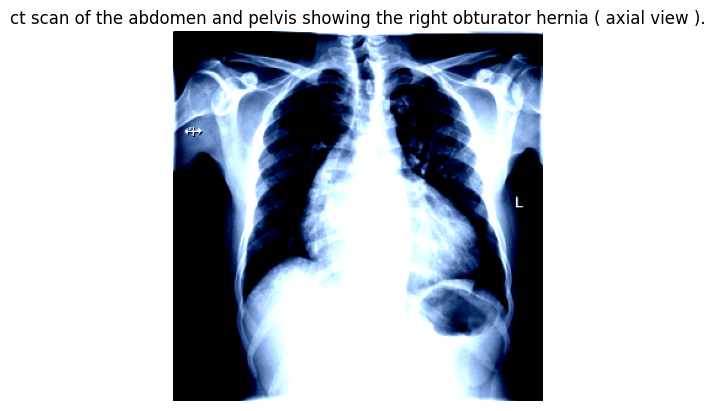

In [36]:
import matplotlib.pyplot as plt

plt.imshow(imgs[0].permute(1, 2, 0))  
plt.axis('off')
plt.title(pred_caption)
plt.show()


In [ ]:
# torch.save(model.state_dict(), MODEL_DIR + "multitask_model_final.pth")

# import pickle
# with open(MODEL_DIR + "tokenizer.pkl", "wb") as f:
#     pickle.dump(tokenizer, f)
